In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [141]:
exp_ids=['2018_06_22_17_41_33_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_17_52_42_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_18_03_53_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_18_22_16_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_18_33_40_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_18_45_32_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_18_57_18_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_19_07_58_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_19_19_21_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_19_31_06_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_19_42_46_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_19_54_28_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_20_06_27_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_20_17_40_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_20_28_05_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_20_37_43_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_20_47_41_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_20_57_08_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_21_07_11_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_21_16_46_Closed loop Ramsey, temperature controlled box',
         '2018_06_22_21_26_21_Closed loop Ramsey, temperature controlled box'
]

In [142]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_17_41_33_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_17_52_42_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_03_53_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_22_16_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_33_40_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_45_32_Closed loop Ramsey, temperature con

# Experiment-wise analysis

2018_06_22_17_41_33_Closed loop Ramsey, temperature controlled box
0


<IPython.core.display.Javascript object>


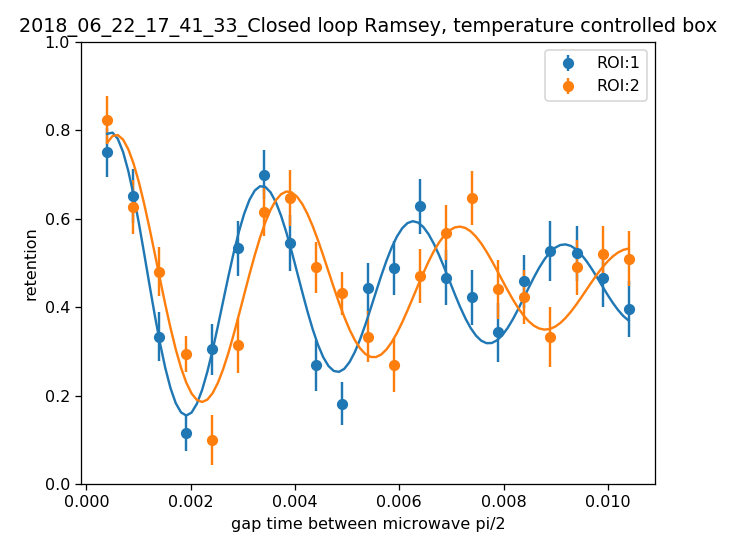

[0.017, 0.29560964114929822, 310, 1.5707963267948966, 0.45439035885070178]
tau 1  is  0.00690005311249  with 1 std of   0.00121214933545
amplitude 1  is  0.379631699295  with 1 std of   0.0366989653382
frequency 1  is  344.794330283  with 1 std of   4.55187368387
phase 1  is  0.49424005545  with 1 std of   0.118360224927
offset 1  is  0.441766576282  with 1 std of   0.00979821733414
[0.017, 0.35552538964303665, 310, 1.5707963267948966, 0.46800402212166919]
tau 2  is  0.00690835549302  with 1 std of   0.00174804208705
amplitude 2  is  0.368153296036  with 1 std of   0.0517379769126
frequency 2  is  303.770923735  with 1 std of   6.83568500764
phase 2  is  0.410231106436  with 1 std of   0.17638443036
offset 2  is  0.451927087244  with 1 std of   0.0140060034551
2018_06_22_17_52_42_Closed loop Ramsey, temperature controlled box
1


<IPython.core.display.Javascript object>


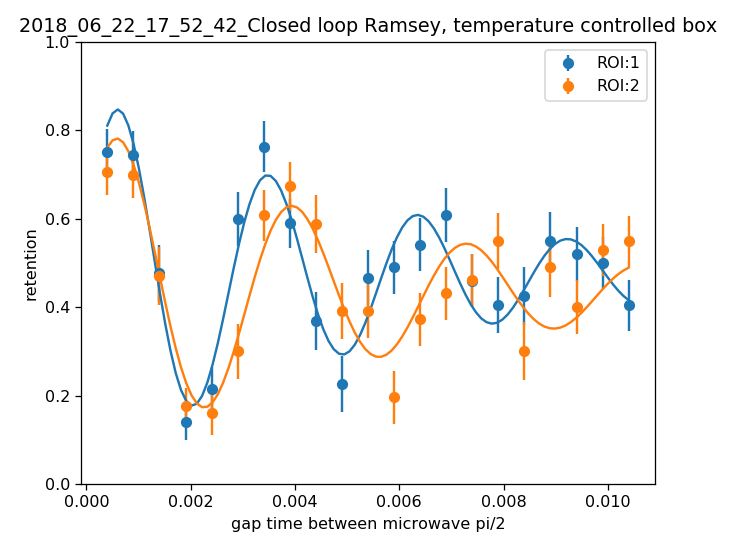

[0.017, 0.27532479898221668, 310, 1.5707963267948966, 0.48783309575462547]
tau 1  is  0.00573734296278  with 1 std of   0.00120059055139
amplitude 1  is  0.41978394839  with 1 std of   0.0530140655398
frequency 1  is  347.90346981  with 1 std of   6.3193998667
phase 1  is  0.179450008859  with 1 std of   0.149167421879
offset 1  is  0.470390697167  with 1 std of   0.0129471312234
[0.017, 0.25609207785678378, 310, 1.5707963267948966, 0.44979027508439273]
tau 2  is  0.00581500942067  with 1 std of   0.00175548601101
amplitude 2  is  0.386215034076  with 1 std of   0.0691279009484
frequency 2  is  298.378641506  with 1 std of   9.38205342738
phase 2  is  0.386232108387  with 1 std of   0.225185276691
offset 2  is  0.433794201005  with 1 std of   0.0176376144351
2018_06_22_18_03_53_Closed loop Ramsey, temperature controlled box
2


<IPython.core.display.Javascript object>


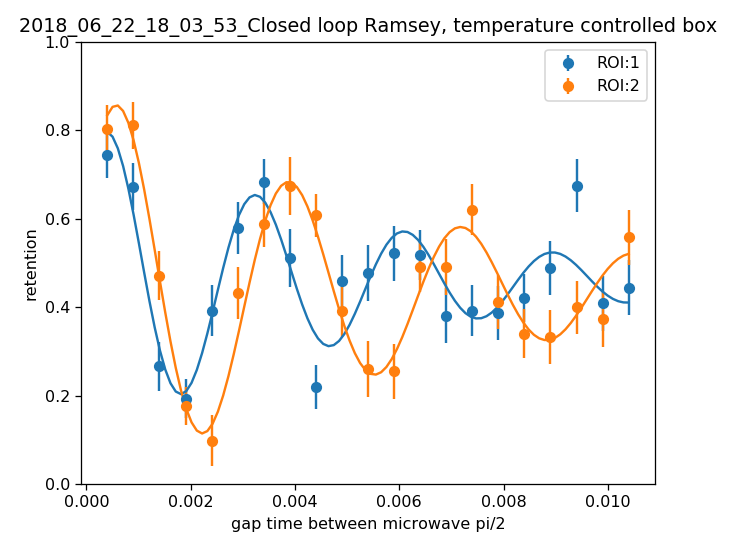

[0.017, 0.27617307661323687, 310, 1.5707963267948966, 0.46850777445059288]
tau 1  is  0.00517595174642  with 1 std of   0.00152548702931
amplitude 1  is  0.364691855199  with 1 std of   0.066979834308
frequency 1  is  350.801384554  with 1 std of   10.5328445885
phase 1  is  0.636358595171  with 1 std of   0.234376594112
offset 1  is  0.459349023607  with 1 std of   0.0164222915305
[0.017, 0.35495605886282905, 310, 1.5707963267948966, 0.45636469585415212]
tau 2  is  0.00620173887896  with 1 std of   0.00101355226914
amplitude 2  is  0.46270428518  with 1 std of   0.0440174295112
frequency 2  is  302.870591128  with 1 std of   4.88742079132
phase 2  is  0.398991858231  with 1 std of   0.120243395845
offset 2  is  0.43642901588  with 1 std of   0.0115170669429
2018_06_22_18_22_16_Closed loop Ramsey, temperature controlled box
3


<IPython.core.display.Javascript object>


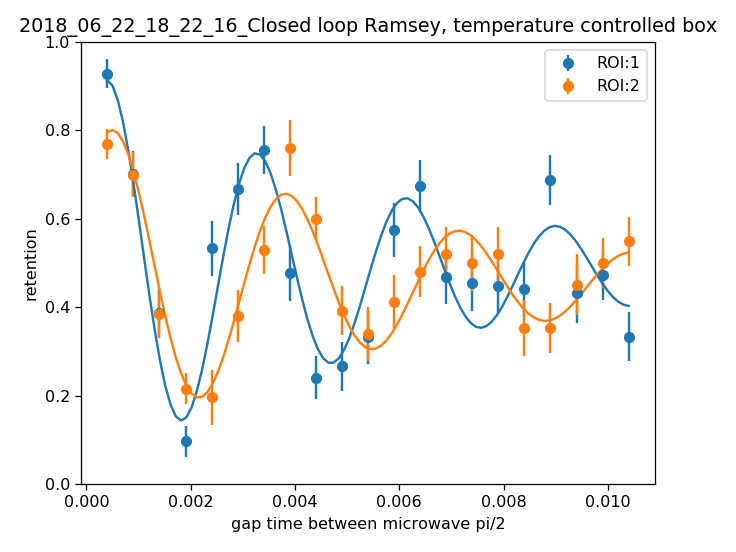

[0.017, 0.43468155712854262, 310, 1.5707963267948966, 0.49388987144288599]
tau 1  is  0.00594522738843  with 1 std of   0.00163299325801
amplitude 1  is  0.461812637564  with 1 std of   0.0752315069663
frequency 1  is  348.780966464  with 1 std of   8.48222352093
phase 1  is  0.641493794887  with 1 std of   0.203581792733
offset 1  is  0.482361581618  with 1 std of   0.0192674212251
[0.017, 0.29757236227824468, 310, 1.5707963267948966, 0.47165840695252459]
tau 2  is  0.00611077205637  with 1 std of   0.00117388107684
amplitude 2  is  0.374092053024  with 1 std of   0.041897237368
frequency 2  is  300.988058134  with 1 std of   5.93594504765
phase 2  is  0.548589707967  with 1 std of   0.14524787004
offset 2  is  0.457140404605  with 1 std of   0.0110882897265
2018_06_22_18_33_40_Closed loop Ramsey, temperature controlled box
4


<IPython.core.display.Javascript object>


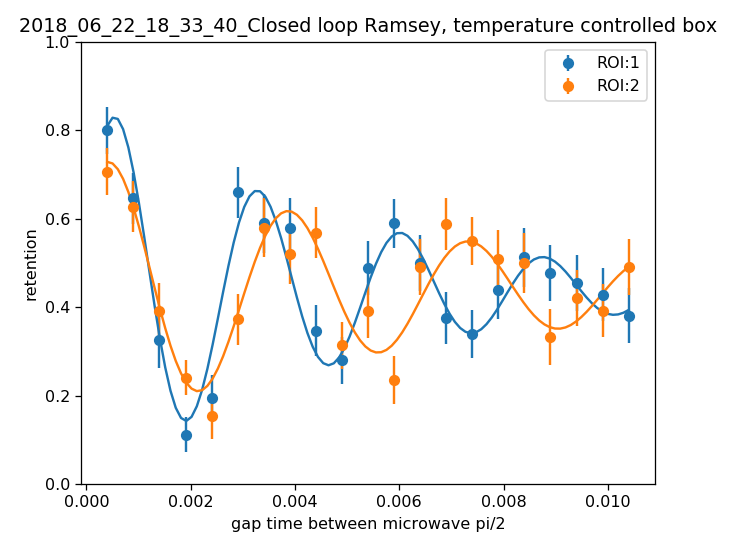

[0.017, 0.34672725953556555, 310, 1.5707963267948966, 0.4532727404644345]
tau 1  is  0.00494906919541  with 1 std of   0.000914993897036
amplitude 1  is  0.437523854507  with 1 std of   0.0514323473453
frequency 1  is  365.35394835  with 1 std of   6.71401414729
phase 1  is  0.247772549113  with 1 std of   0.145024672774
offset 1  is  0.439067866284  with 1 std of   0.0121612291625
[0.017, 0.25947137829490768, 310, 1.5707963267948966, 0.44641097464626883]
tau 2  is  0.00715304364998  with 1 std of   0.00225545861505
amplitude 2  is  0.308821162161  with 1 std of   0.0520653693964
frequency 2  is  289.717414921  with 1 std of   7.9205716515
phase 2  is  0.740599674093  with 1 std of   0.21110882709
offset 2  is  0.438151851452  with 1 std of   0.0143776450074
2018_06_22_18_45_32_Closed loop Ramsey, temperature controlled box
5


<IPython.core.display.Javascript object>


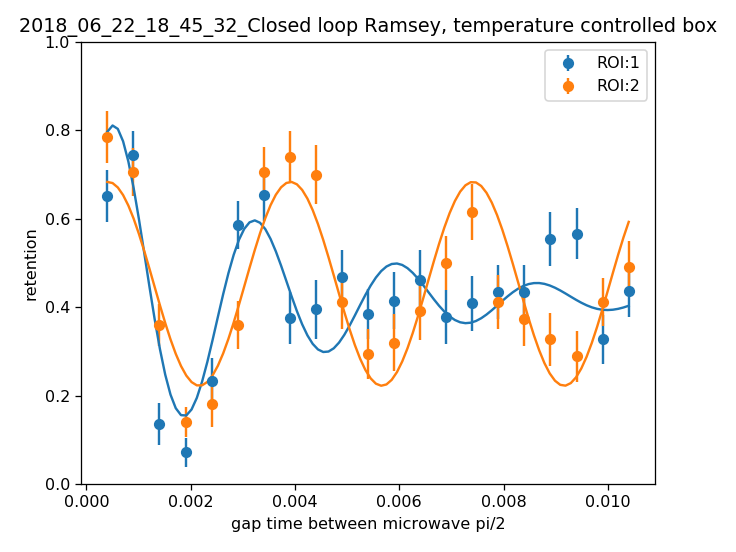

[0.017, 0.31061298000281057, 310, 1.5707963267948966, 0.43406787106101918]
tau 1  is  0.00342220578964  with 1 std of   0.00120444453612
amplitude 1  is  0.460534131082  with 1 std of   0.111022862735
frequency 1  is  369.373859173  with 1 std of   18.7017629993
phase 1  is  0.249320656903  with 1 std of   0.316040689698
offset 1  is  0.418143550759  with 1 std of   0.0224604209201
[0.017, 0.33140127846010198, 310, 1.5707963267948966, 0.45291244703009409]
tau 2  is  -259239.794597  with 1 std of   1.21330260834e+12
amplitude 2  is  0.230588033888  with 1 std of   0.0424278240747
frequency 2  is  285.880297978  with 1 std of   6.96711265994
phase 2  is  0.821634429341  with 1 std of   0.277433488265
offset 2  is  0.452789222644  with 1 std of   0.0212943986505
2018_06_22_18_57_18_Closed loop Ramsey, temperature controlled box
6


<IPython.core.display.Javascript object>


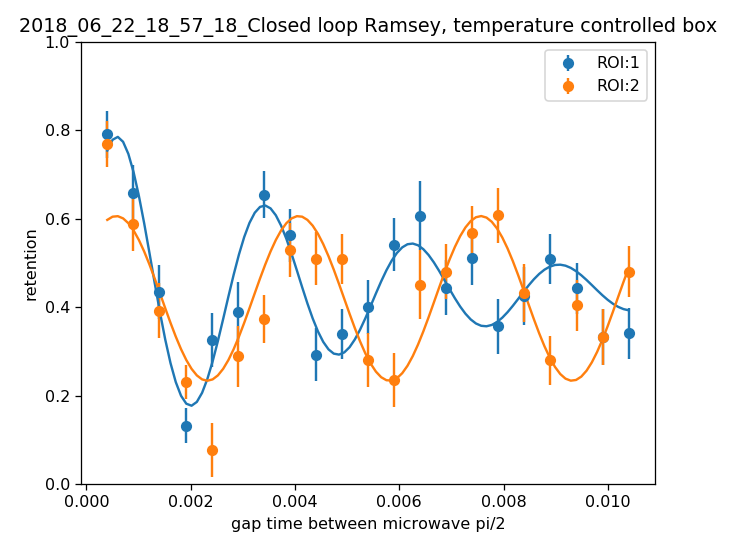

[0.017, 0.33873745458811322, 310, 1.5707963267948966, 0.45196021983049139]
tau 1  is  0.00479493471424  with 1 std of   0.00122529456709
amplitude 1  is  0.395930962305  with 1 std of   0.0654049678759
frequency 1  is  354.095210406  with 1 std of   9.43397303027
phase 1  is  0.169045207833  with 1 std of   0.199404427832
offset 1  is  0.436647085613  with 1 std of   0.0149907553316
[0.017, 0.34929541047188101, 310, 1.5707963267948966, 0.41993535875888827]
tau 2  is  -259529.537275  with 1 std of   1.12728563063e+12
amplitude 2  is  0.186293351527  with 1 std of   0.0385764468431
frequency 2  is  285.939148445  with 1 std of   8.21609537103
phase 2  is  0.54596388646  with 1 std of   0.331893079112
offset 2  is  0.419824261317  with 1 std of   0.0213372568466
2018_06_22_19_07_58_Closed loop Ramsey, temperature controlled box
7


<IPython.core.display.Javascript object>


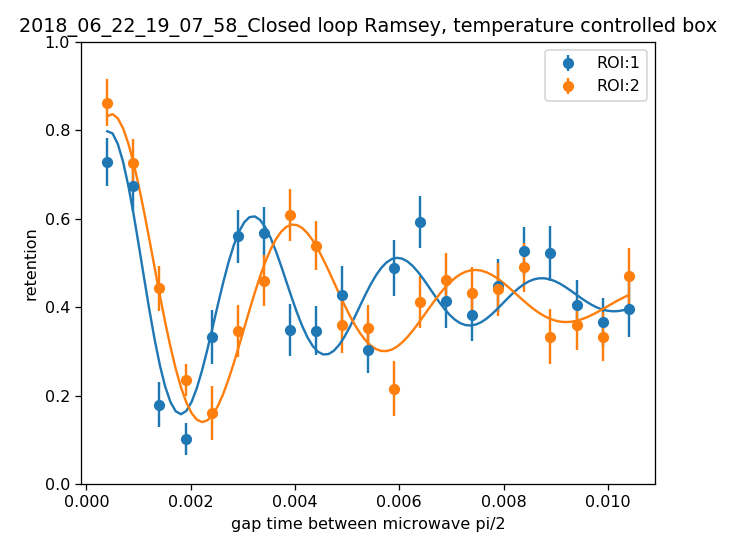

[0.017, 0.29534680459250406, 310, 1.5707963267948966, 0.43381986207416257]
tau 1  is  0.00387197405697  with 1 std of   0.00103956845704
amplitude 1  is  0.423565254246  with 1 std of   0.0754912263228
frequency 1  is  361.082224639  with 1 std of   12.9590156984
phase 1  is  0.492344525238  with 1 std of   0.24031344579
offset 1  is  0.421477956394  with 1 std of   0.0166638286501
[0.017, 0.43231415643180349, 310, 1.5707963267948966, 0.43043094160741224]
tau 2  is  0.00392595839571  with 1 std of   0.000611844454649
amplitude 2  is  0.484901151601  with 1 std of   0.0492547723554
frequency 2  is  286.816502324  with 1 std of   7.37276565437
phase 2  is  0.56064093044  with 1 std of   0.141420454458
offset 2  is  0.412367989973  with 1 std of   0.011156493673
2018_06_22_19_19_21_Closed loop Ramsey, temperature controlled box
8


<IPython.core.display.Javascript object>


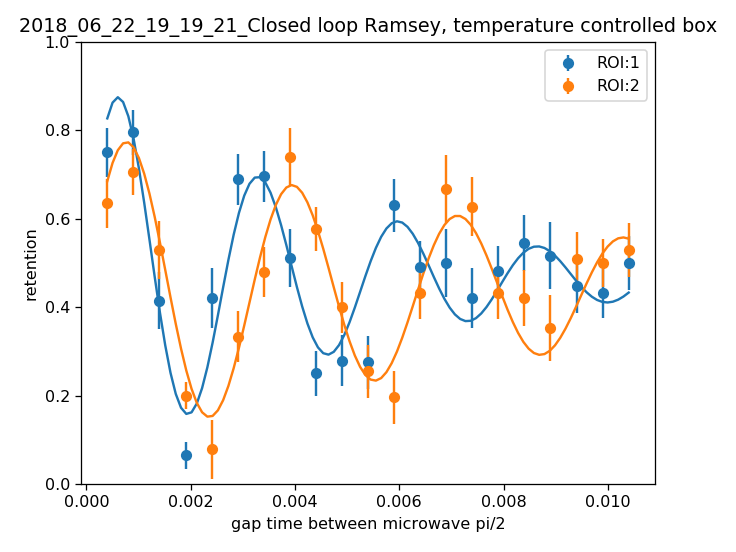

[0.017, 0.31407149967492193, 310, 1.5707963267948966, 0.48138304577962349]
tau 1  is  0.00464622303532  with 1 std of   0.00125139025637
amplitude 1  is  0.468863465007  with 1 std of   0.0828661891841
frequency 1  is  373.035231317  with 1 std of   9.95315522379
phase 1  is  0.0626143434255  with 1 std of   0.205592089877
offset 1  is  0.464994508283  with 1 std of   0.018429711153
[0.017, 0.28292393880629174, 310, 1.5707963267948966, 0.45707606119370825]
tau 2  is  0.00933083100257  with 1 std of   0.00276943405568
amplitude 2  is  0.366860629291  with 1 std of   0.0528877722609
frequency 2  is  315.059633939  with 1 std of   5.62043011136
phase 2  is  -0.00505313137616  with 1 std of   0.158958390857
offset 2  is  0.436186919281  with 1 std of   0.0145051717588
2018_06_22_19_31_06_Closed loop Ramsey, temperature controlled box
9


<IPython.core.display.Javascript object>


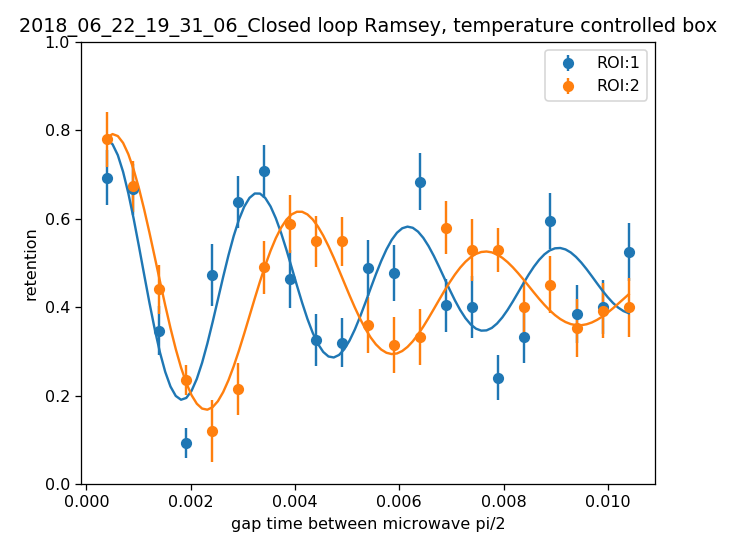

[0.017, 0.24741831931666436, 310, 1.5707963267948966, 0.45989875385406731]
tau 1  is  0.0063211296641  with 1 std of   0.00255615756783
amplitude 1  is  0.349046717855  with 1 std of   0.0814631557098
frequency 1  is  346.106190001  with 1 std of   11.6342063692
phase 1  is  0.656466000048  with 1 std of   0.288581667626
offset 1  is  0.450947455926  with 1 std of   0.0212126214208
[0.017, 0.33797672915319965, 310, 1.5707963267948966, 0.44202327084680038]
tau 2  is  0.00542257826017  with 1 std of   0.00110615629857
amplitude 2  is  0.400894062939  with 1 std of   0.048845027242
frequency 2  is  279.846985099  with 1 std of   6.7160333367
phase 2  is  0.565962951818  with 1 std of   0.157837079423
offset 2  is  0.428833990182  with 1 std of   0.0124146758352
2018_06_22_19_42_46_Closed loop Ramsey, temperature controlled box
10


<IPython.core.display.Javascript object>


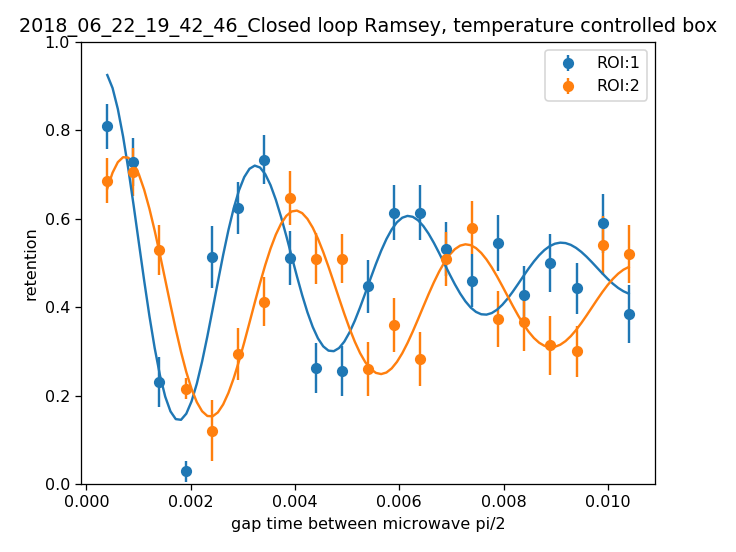

[0.017, 0.32119410629218376, 310, 1.5707963267948966, 0.48832970323162578]
tau 1  is  0.00464766940449  with 1 std of   0.00123779153653
amplitude 1  is  0.490585438627  with 1 std of   0.0843867689526
frequency 1  is  340.871689256  with 1 std of   10.3626728074
phase 1  is  0.814398071801  with 1 std of   0.216679100744
offset 1  is  0.477207227944  with 1 std of   0.0195431279129
[0.017, 0.27567826550068514, 310, 1.5707963267948966, 0.43020408744049138]
tau 2  is  0.00705496986512  with 1 std of   0.00199198343229
amplitude 2  is  0.36543626614  with 1 std of   0.0578134071801
frequency 2  is  306.046361063  with 1 std of   6.87299966511
phase 2  is  0.0666196354611  with 1 std of   0.177216238489
offset 2  is  0.412351212679  with 1 std of   0.0147338795876
2018_06_22_19_54_28_Closed loop Ramsey, temperature controlled box
11


<IPython.core.display.Javascript object>


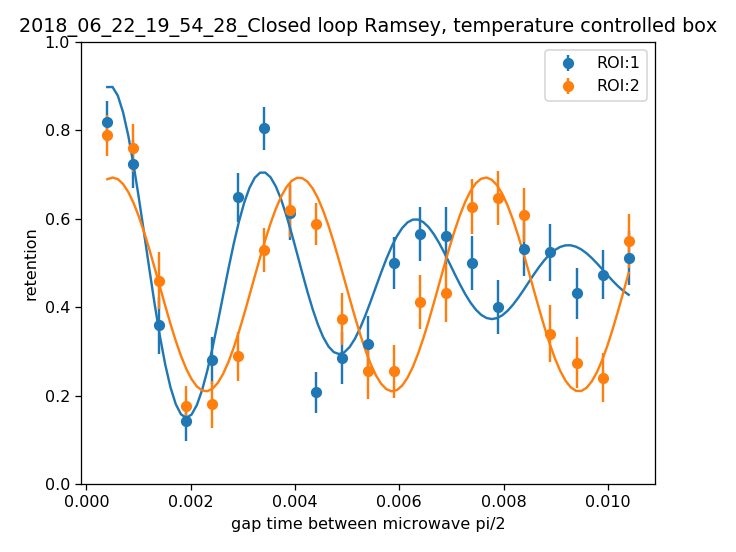

[0.017, 0.33437945237441946, 310, 1.5707963267948966, 0.48562054762558049]
tau 1  is  0.00487748055368  with 1 std of   0.00118270448129
amplitude 1  is  0.475359376134  with 1 std of   0.0722063835341
frequency 1  is  341.291396716  with 1 std of   8.97723814868
phase 1  is  0.508052016091  with 1 std of   0.195379360864
offset 1  is  0.469147474671  with 1 std of   0.0173257586273
[0.017, 0.34072757308051421, 310, 1.5707963267948966, 0.44773396538102422]
tau 2  is  -175747.284063  with 1 std of   780923065539.0
amplitude 2  is  0.241881011279  with 1 std of   0.0453807763554
frequency 2  is  279.583608606  with 1 std of   5.44068091101
phase 2  is  0.688151275168  with 1 std of   0.219888364703
offset 2  is  0.451440516775  with 1 std of   0.0181554592554
2018_06_22_20_06_27_Closed loop Ramsey, temperature controlled box
12


<IPython.core.display.Javascript object>


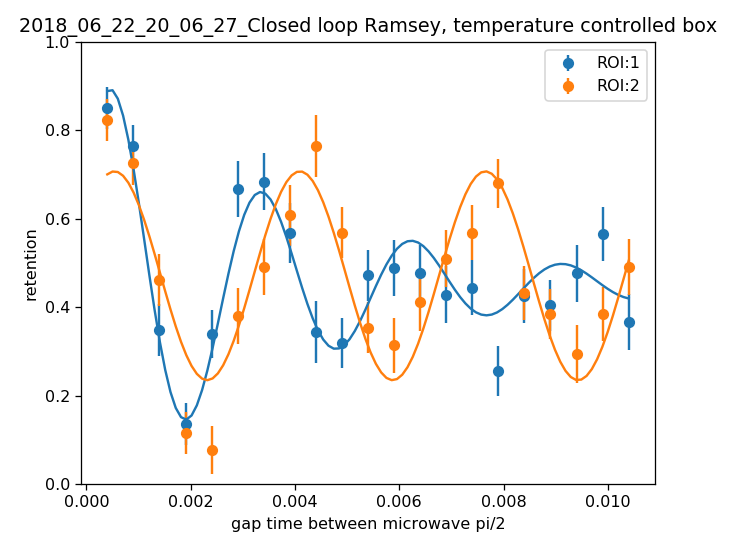

[0.017, 0.38238996078476067, 310, 1.5707963267948966, 0.4676100392152393]
tau 1  is  0.00387845944163  with 1 std of   0.000816495273275
amplitude 1  is  0.501244601463  with 1 std of   0.0699346847177
frequency 1  is  346.665408528  with 1 std of   10.0620868724
phase 1  is  0.452819147594  with 1 std of   0.187610769999
offset 1  is  0.450394581169  with 1 std of   0.0153774394711
[0.017, 0.35514759750053859, 310, 1.5707963267948966, 0.46838181426416725]
tau 2  is  -404566.213916  with 1 std of   2.25188822937e+12
amplitude 2  is  0.236263356936  with 1 std of   0.0430259708316
frequency 2  is  281.149828786  with 1 std of   6.90886833893
phase 2  is  0.621794983686  with 1 std of   0.279383892562
offset 2  is  0.471033057519  with 1 std of   0.0223413421015
2018_06_22_20_17_40_Closed loop Ramsey, temperature controlled box
13


<IPython.core.display.Javascript object>


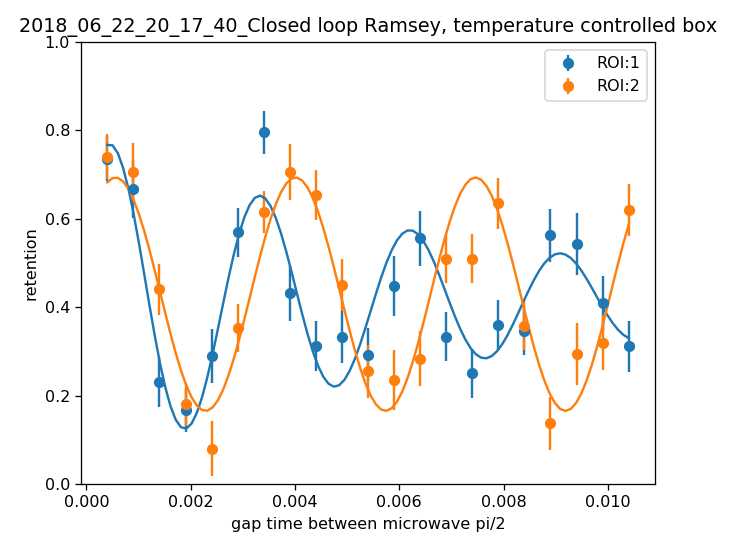

[0.017, 0.37007960779262944, 310, 1.5707963267948966, 0.42583875955430933]
tau 1  is  0.00722341087004  with 1 std of   0.00212099974105
amplitude 1  is  0.377165406541  with 1 std of   0.0599158533538
frequency 1  is  347.409957398  with 1 std of   7.37026125563
phase 1  is  0.535698288523  with 1 std of   0.194421544076
offset 1  is  0.414779498554  with 1 std of   0.0162349536557
[0.017, 0.30751341271874011, 310, 1.5707963267948966, 0.43248658728125988]
tau 2  is  -149270.385675  with 1 std of   356291092591.0
amplitude 2  is  0.264064129017  with 1 std of   0.0403437794171
frequency 2  is  289.76547345  with 1 std of   4.81238844438
phase 2  is  0.552051274526  with 1 std of   0.19276713316
offset 2  is  0.429367212029  with 1 std of   0.0168269646022
2018_06_22_20_28_05_Closed loop Ramsey, temperature controlled box
14


<IPython.core.display.Javascript object>


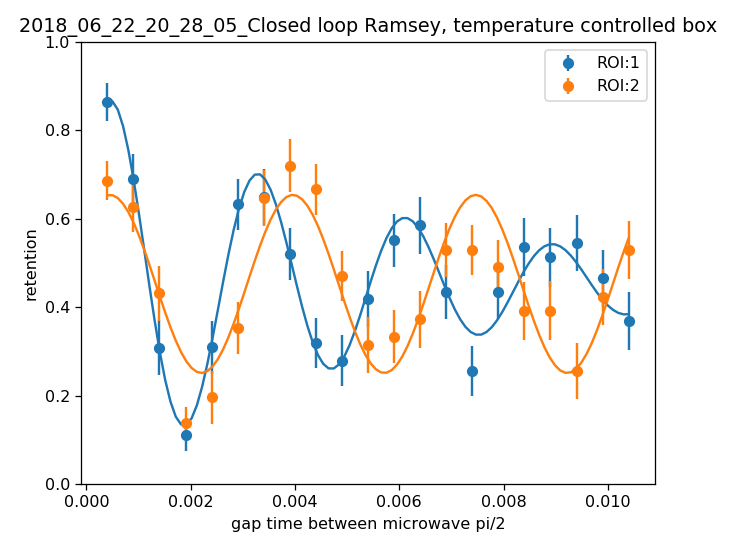

[0.017, 0.39742245480858379, 310, 1.5707963267948966, 0.46621390882777985]
tau 1  is  0.00554080103382  with 1 std of   0.000697403667283
amplitude 1  is  0.451375856715  with 1 std of   0.034573162984
frequency 1  is  354.100456763  with 1 std of   4.1921708156
phase 1  is  0.466785494573  with 1 std of   0.0968671703814
offset 1  is  0.452973178343  with 1 std of   0.00867825889896
[0.017, 0.26780866192630898, 310, 1.5707963267948966, 0.452191338073691]
tau 2  is  -342292.700241  with 1 std of   1.44711984384e+12
amplitude 2  is  0.201488134819  with 1 std of   0.0327536860986
frequency 2  is  285.111373182  with 1 std of   6.51317496685
phase 2  is  0.762177481592  with 1 std of   0.260902271553
offset 2  is  0.452564714528  with 1 std of   0.0174431117502
2018_06_22_20_37_43_Closed loop Ramsey, temperature controlled box
15


<IPython.core.display.Javascript object>


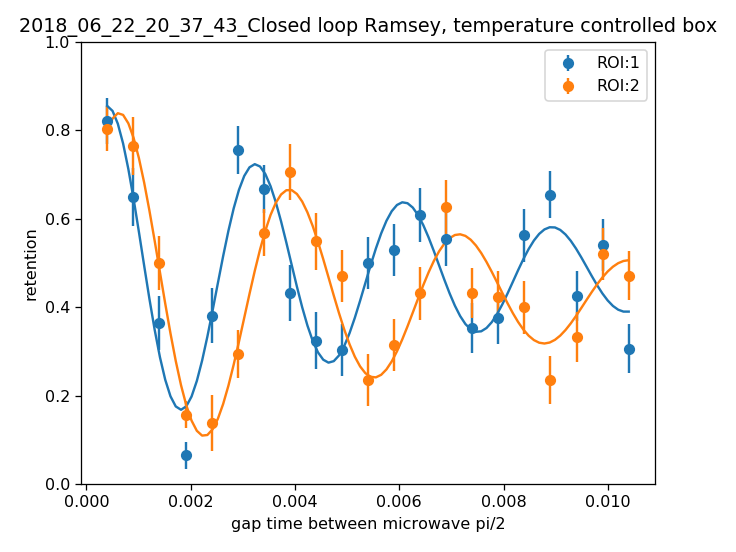

[0.017, 0.33632273351388259, 310, 1.5707963267948966, 0.4841900869989379]
tau 1  is  0.00668861800278  with 1 std of   0.00188708130312
amplitude 1  is  0.403823457483  with 1 std of   0.064441065832
frequency 1  is  351.413852543  with 1 std of   7.76698974638
phase 1  is  0.642236717563  with 1 std of   0.196722611028
offset 1  is  0.475151405518  with 1 std of   0.0170903018335
[0.017, 0.35761258349493646, 310, 1.5707963267948966, 0.44630898513251455]
tau 2  is  0.00601576185167  with 1 std of   0.00111028307295
amplitude 2  is  0.461862025163  with 1 std of   0.0508218929102
frequency 2  is  306.737296817  with 1 std of   5.61950280529
phase 2  is  0.275215236415  with 1 std of   0.135341151129
offset 2  is  0.424720377751  with 1 std of   0.0129060537519
2018_06_22_20_47_41_Closed loop Ramsey, temperature controlled box
16


<IPython.core.display.Javascript object>


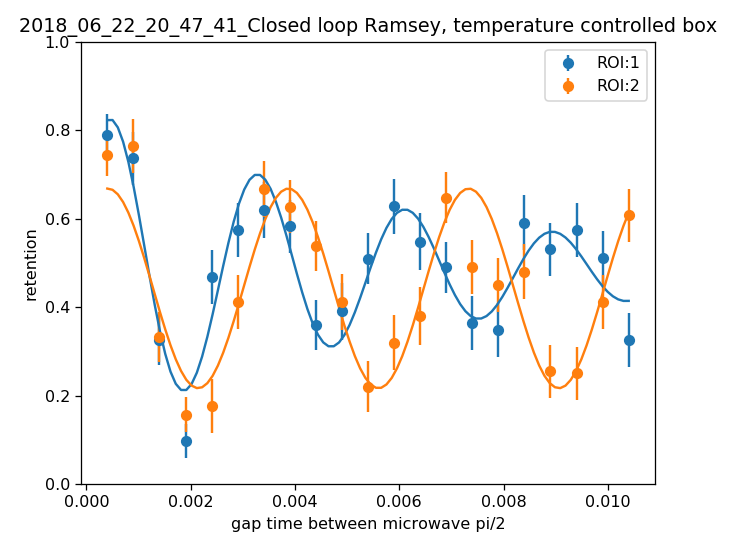

[0.017, 0.29490049135081342, 310, 1.5707963267948966, 0.49356104711072502]
tau 1  is  0.00621927884502  with 1 std of   0.00165614845562
amplitude 1  is  0.368709747328  with 1 std of   0.0571758118933
frequency 1  is  353.684171731  with 1 std of   7.89641254414
phase 1  is  0.495630242632  with 1 std of   0.193507298198
offset 1  is  0.483396244892  with 1 std of   0.0148869519178
[0.017, 0.31969044027867555, 310, 1.5707963267948966, 0.44501544207426558]
tau 2  is  -348623.085341  with 1 std of   1.60040833121e+12
amplitude 2  is  0.225855195217  with 1 std of   0.0413053670768
frequency 2  is  289.070079043  with 1 std of   7.04366084055
phase 2  is  0.819668476713  with 1 std of   0.273428418575
offset 2  is  0.442488073029  with 1 std of   0.0202320099942
2018_06_22_20_57_08_Closed loop Ramsey, temperature controlled box
17


<IPython.core.display.Javascript object>


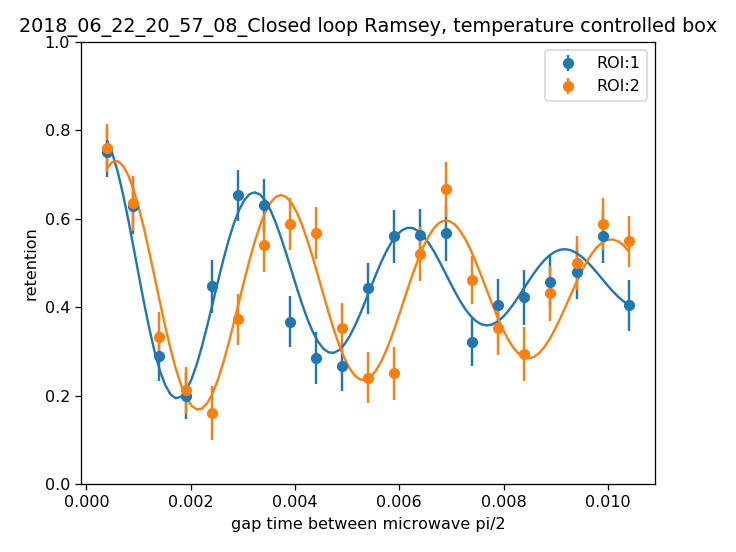

[0.017, 0.28825787604707703, 310, 1.5707963267948966, 0.46174212395292297]
tau 1  is  0.00598109992729  with 1 std of   0.00161203638007
amplitude 1  is  0.351184497429  with 1 std of   0.0566549036544
frequency 1  is  336.381571514  with 1 std of   7.77915923417
phase 1  is  0.96421134916  with 1 std of   0.187258530131
offset 1  is  0.455605130113  with 1 std of   0.0139290570437
[0.017, 0.31353659412482937, 310, 1.5707963267948966, 0.44646340587517064]
tau 2  is  0.0107154778745  with 1 std of   0.00358377339285
amplitude 2  is  0.318895780911  with 1 std of   0.0461319719043
frequency 2  is  315.871454309  with 1 std of   5.83337985162
phase 2  is  0.406863997505  with 1 std of   0.175199914234
offset 2  is  0.428867224084  with 1 std of   0.0138159027415
2018_06_22_21_07_11_Closed loop Ramsey, temperature controlled box
18


<IPython.core.display.Javascript object>


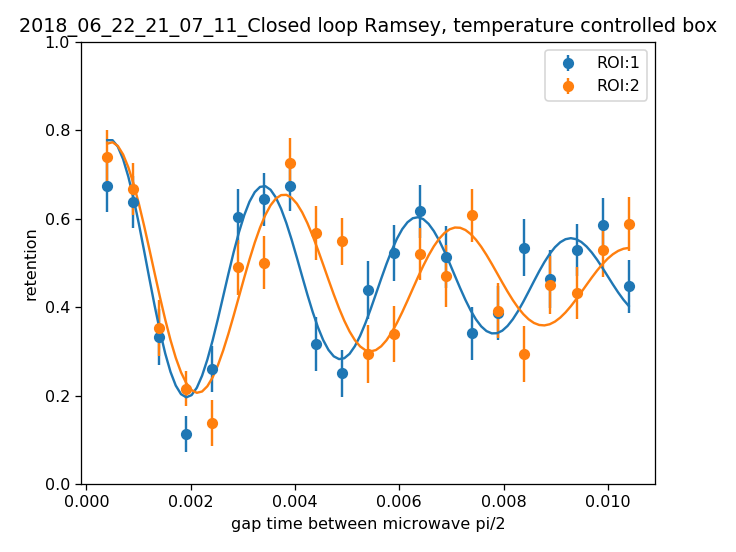

[0.017, 0.20344914407038739, 310, 1.5707963267948966, 0.47096946058077538]
tau 1  is  0.00740725509815  with 1 std of   0.00232403093648
amplitude 1  is  0.3415072576  with 1 std of   0.0564692973722
frequency 1  is  339.36177584  with 1 std of   7.39593265938
phase 1  is  0.547402418048  with 1 std of   0.200034524653
offset 1  is  0.458837537768  with 1 std of   0.0153306925439
[0.017, 0.27025210084033618, 310, 1.5707963267948966, 0.46974789915966381]
tau 2  is  0.00705724350439  with 1 std of   0.00252570452271
amplitude 2  is  0.339931303845  with 1 std of   0.0667145499444
frequency 2  is  301.854926192  with 1 std of   9.64115395553
phase 2  is  0.589231142005  with 1 std of   0.251180655005
offset 2  is  0.456603221838  with 1 std of   0.0184322270547
2018_06_22_21_16_46_Closed loop Ramsey, temperature controlled box
19


<IPython.core.display.Javascript object>


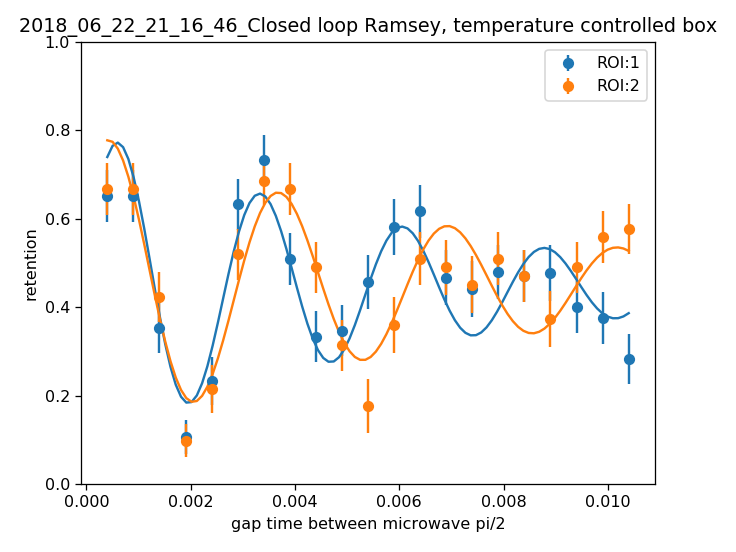

[0.017, 0.27617169680867426, 310, 1.5707963267948966, 0.45716163652465902]
tau 1  is  0.00626279335828  with 1 std of   0.00188116023457
amplitude 1  is  0.360010287796  with 1 std of   0.0636076886533
frequency 1  is  366.537203508  with 1 std of   8.45271184077
phase 1  is  0.13528555374  with 1 std of   0.206283600502
offset 1  is  0.445631549642  with 1 std of   0.0160334633578
[0.017, 0.22378869496516551, 310, 1.5707963267948966, 0.46248581483875606]
tau 2  is  0.00729719374677  with 1 std of   0.00232824230331
amplitude 2  is  0.349548650381  with 1 std of   0.0605949762191
frequency 2  is  307.68139639  with 1 std of   8.38371663687
phase 2  is  0.681564232936  with 1 std of   0.220479710371
offset 2  is  0.448764062993  with 1 std of   0.0168165925729
2018_06_22_21_26_21_Closed loop Ramsey, temperature controlled box
20


<IPython.core.display.Javascript object>


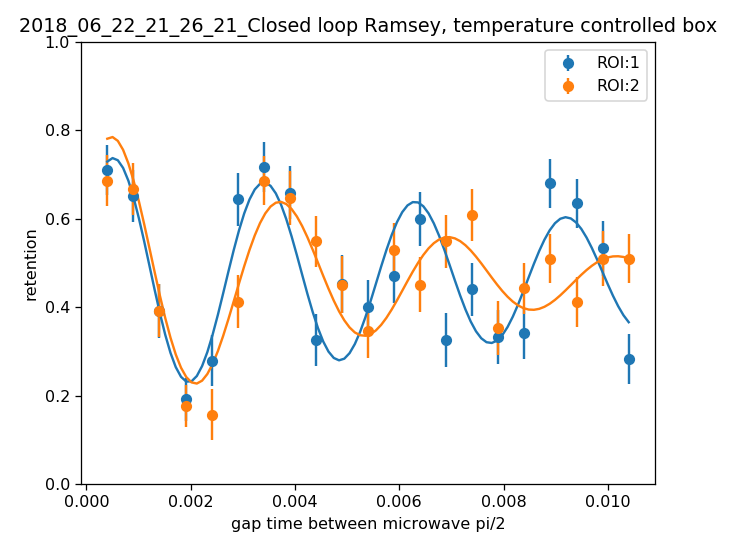

[0.017, 0.23816137590922926, 310, 1.5707963267948966, 0.4792299284385968]
tau 1  is  0.01255156115  with 1 std of   0.00804533553825
amplitude 1  is  0.279381572282  with 1 std of   0.068138653318
frequency 1  is  345.568295135  with 1 std of   8.94742312139
phase 1  is  0.420973596658  with 1 std of   0.283631686185
offset 1  is  0.469342618408  with 1 std of   0.0206710353553
[0.017, 0.20801910507792859, 310, 1.5707963267948966, 0.47825540472599298]
tau 2  is  0.00529014092766  with 1 std of   0.0016299098846
amplitude 2  is  0.353493347545  with 1 std of   0.0673387171839
frequency 2  is  309.776252154  with 1 std of   11.1533919076
phase 2  is  0.538590764705  with 1 std of   0.252216523352
offset 2  is  0.463774365218  with 1 std of   0.0169741109088


In [143]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=[ '#ff7f0e','#1f77b4','#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.006, 0.43, 409 ,1.107, 0.47]
    #fit_guesses2=[  0.522, 0.411, 190 ,1.52, 0.5]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        offsetguess = np.mean(reten)
        Ampguess = np.max(reten)-offsetguess
        fit_guesses = [0.017,Ampguess , 310 ,np.pi/2, offsetguess]   
        print fit_guesses
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
       # yfit2=decaying_sin(xarray, 0.522, 0.411, 190 ,1.52, 0.5)
        plt.plot(xarray,yfit,color=colors[roi])
       # plt.plot(xarray,yfit2,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(0.5*int(assorted['timestamps'][i][0]+assorted['timestamps'][i][-1])).strftime('%Y-%m-%d %H:%M:%S')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


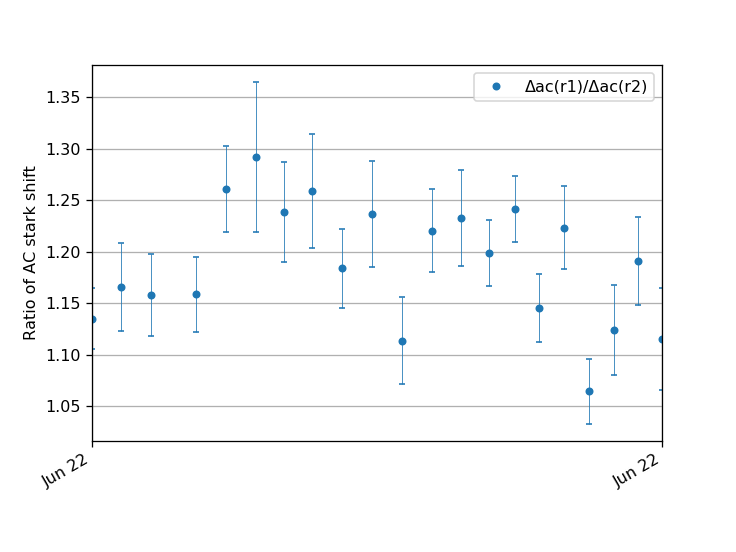

<IPython.core.display.Javascript object>


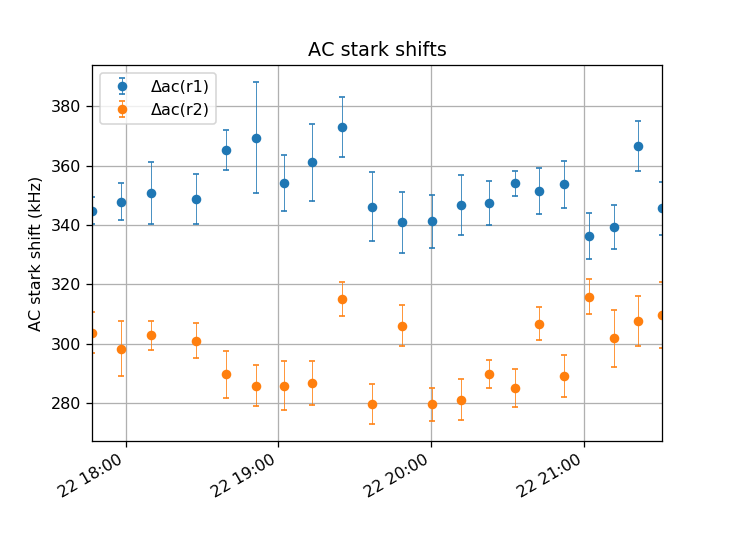

In [144]:
savefig=False
ratio_data=[]
ratio_error=[]
# avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]
# endtime=[]
# endtime_in_UNIX=[]
middletime=[]
# middletime_in_UNIX=[]

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ROI1_ac.append(data11[i][2])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    ratio_error.append(error_total)
    middletime.append(dt.datetime.fromtimestamp(0.5*int(assorted['timestamps'][i][0]+assorted['timestamps'][i][-1])))

# Plotting by clock time
df=pd.DataFrame({ "Δac(r1)/Δac(r2)": ratio_data,'error': ratio_error
                 ,"Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac, 'ROI1_err': ROI1_err, 'ROI2_err': ROI2_err
                 ,"middletime":middletime, "startingtime":startingtime
                },index=middletime)
ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
#ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

# AC stark shifts
ax=df.plot(y=["Δac(r1)"],yerr='ROI1_err',capsize=2,alpha=1,lw=0.5,marker='o',markersize=5,linestyle='None')
df.plot(y=["Δac(r2)"],yerr='ROI2_err',capsize=2,alpha=1,lw=0.5,marker='o',markersize=5,linestyle='None',ax=ax)
hours=md.HourLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shifts')
ax.legend()


<IPython.core.display.Javascript object>


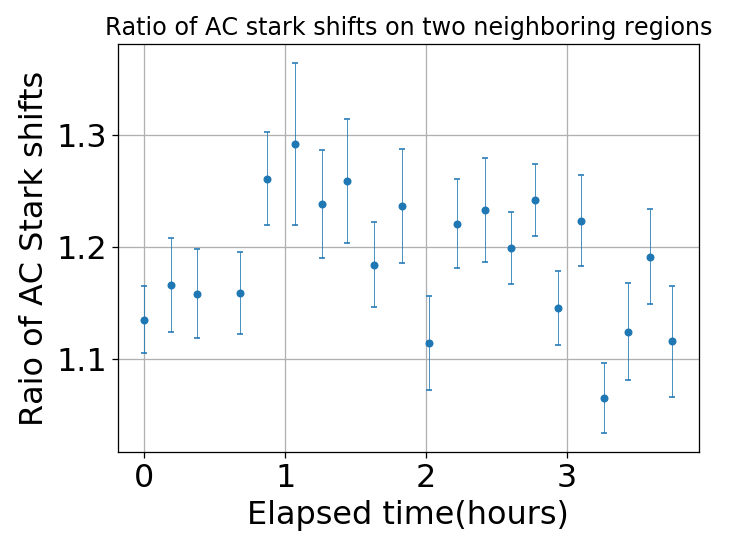

In [145]:
# Plotting by Time difference

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
#fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [146]:
peakshift=825 # kHz
wx=8.1 # um
spacing = 9.25 # um

def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res

ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 21
doing 1-th fit.. out of 21
doing 2-th fit.. out of 21
doing 3-th fit.. out of 21
doing 4-th fit.. out of 21
doing 5-th fit.. out of 21
doing 6-th fit.. out of 21
doing 7-th fit.. out of 21
doing 8-th fit.. out of 21
doing 9-th fit.. out of 21
doing 10-th fit.. out of 21
doing 11-th fit.. out of 21
doing 12-th fit.. out of 21
doing 13-th fit.. out of 21
doing 14-th fit.. out of 21
doing 15-th fit.. out of 21
doing 16-th fit.. out of 21
doing 17-th fit.. out of 21
doing 18-th fit.. out of 21
doing 19-th fit.. out of 21
doing 20-th fit.. out of 21


<IPython.core.display.Javascript object>


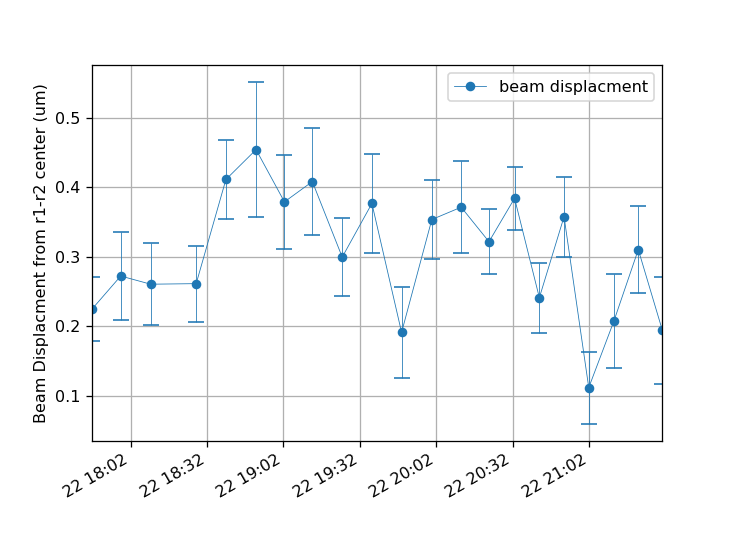

<IPython.core.display.Javascript object>


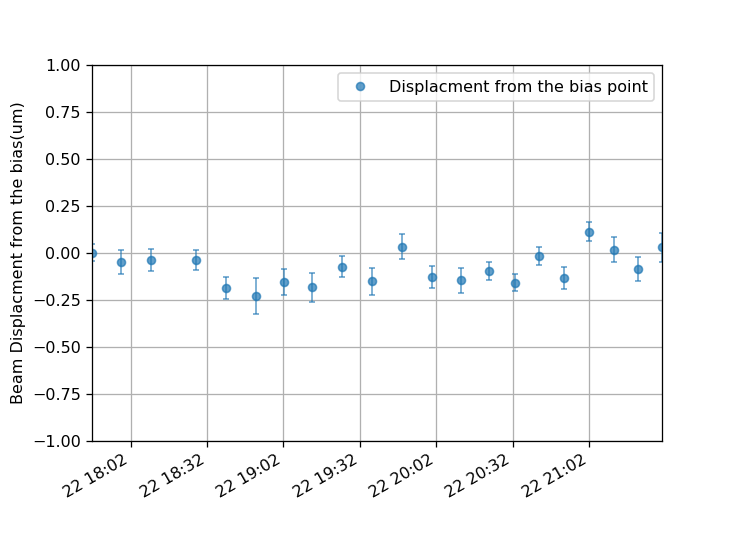

In [147]:
bias_point=np.array(ratio_to_dist[0])
displacement_frombias=ratio_to_dist-bias_point
df_displacement=pd.DataFrame({ "beam displacment": ratio_to_dist,"Displacment from the bias point":-displacement_frombias,'Max_error': dist_max_error,'Min_error': dist_min_error}
                             ,index=middletime)
ax=df_displacement.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
#ax.set_xlim(dt.datetime(2018,6,17,12),dt.datetime(2018,6,18,13,0))
ax.grid()
ax=df_displacement.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_ylim(-1,1)
ax.grid()

<IPython.core.display.Javascript object>


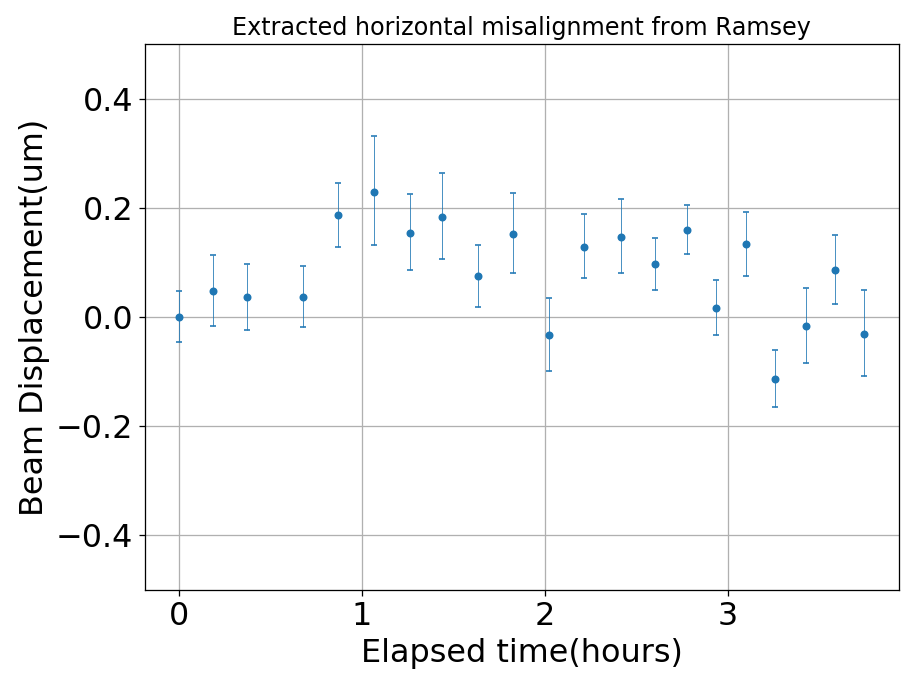

In [148]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Beam Displacement(um)',fontsize=20)
ax.set_title('Extracted horizontal misalignment from Ramsey',fontsize=15)
ax.set_ylim(-0.5,0.5)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Extracted_horizontal_misalignment_from_Ramsey'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [149]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=[
        ]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_17_41_33_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_17_52_42_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_03_53_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_22_16_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_33_40_Closed loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_18_45_32_Closed loop Ramsey, temperature con

<IPython.core.display.Javascript object>


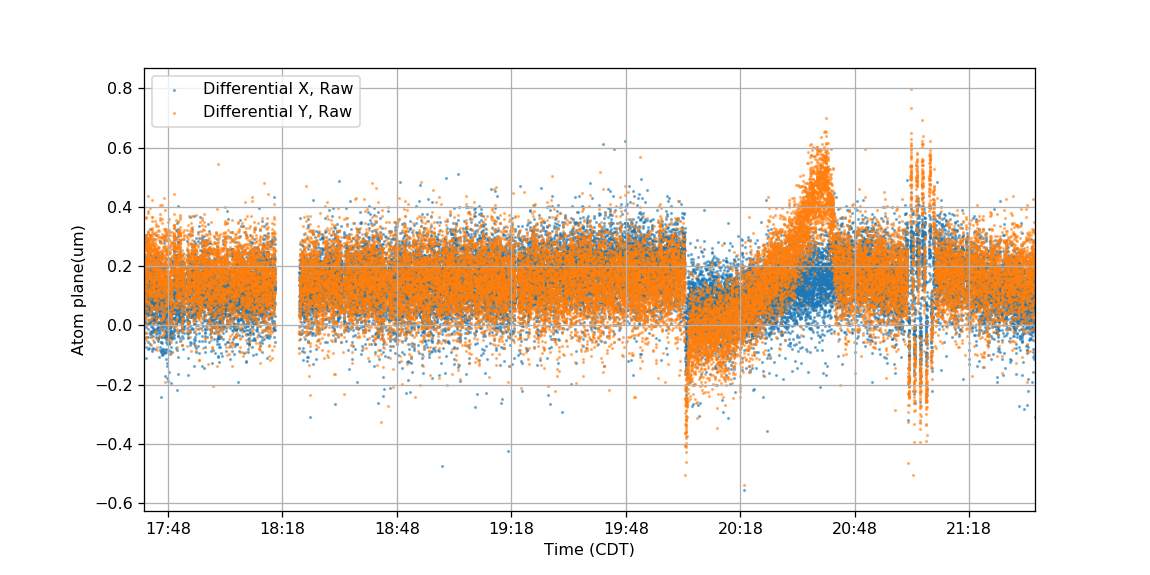

In [150]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
experiment_start_time=flattendedtimestamps[0]
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=1,alpha=0.5,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
#ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=1,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

# Insert room temperature history

<IPython.core.display.Javascript object>


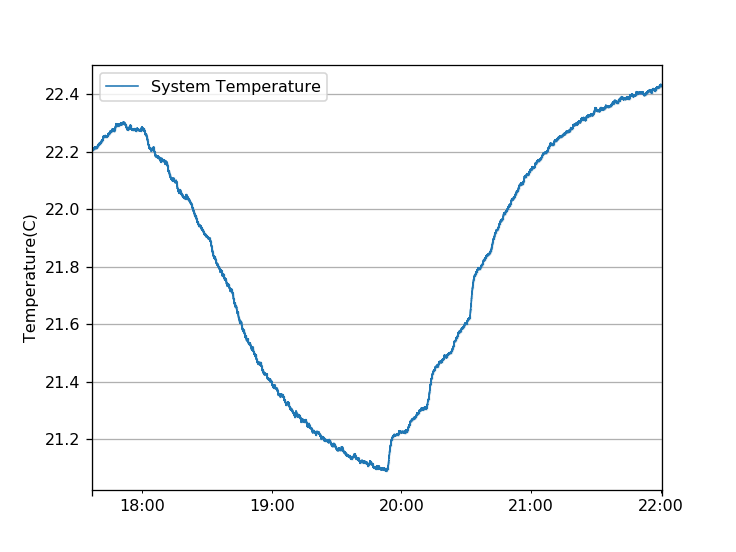

In [153]:
from numpy import genfromtxt
import pandas as pd
my_data=genfromtxt('Rb_labtemperature_20180622.csv',delimiter=',')
data_cutoff=1470 # to cutoff bad data at the beginning
temperatures_in_C=np.array(my_data[data_cutoff:,1])
flattendedtimestamps_temp=np.array(my_data[data_cutoff:,0])/2**32
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps_temp]
samplerate='1S'
df_temperature=pd.DataFrame({'System Temperature': temperatures_in_C,
                },index=dates)

data_to_plot2=df_temperature.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['System Temperature'],alpha=1,lw=1,marker='.',markersize=0.02)
ax.set_ylabel('Temperature(C)')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


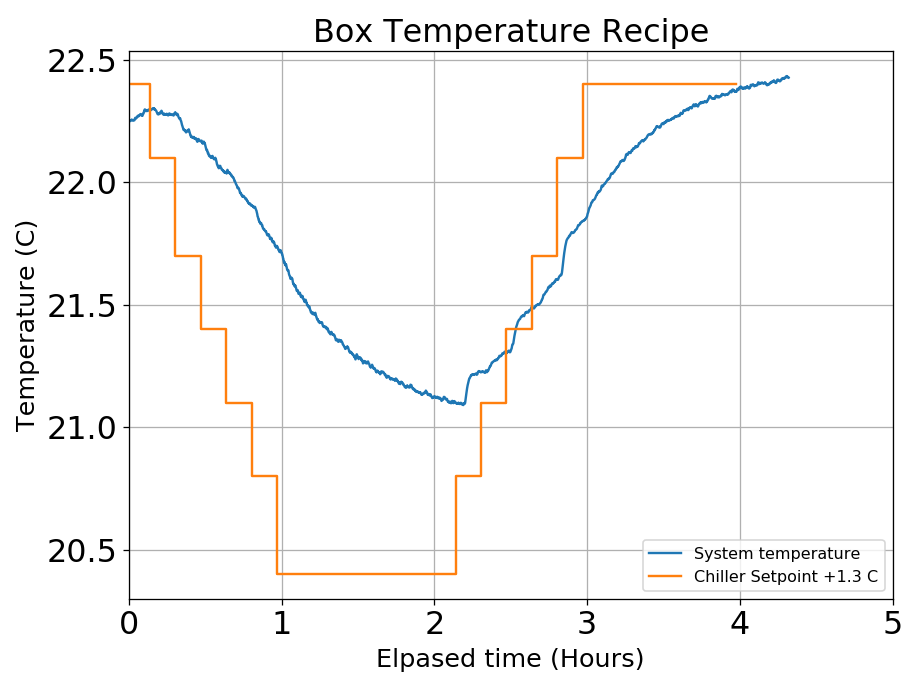

In [154]:
cooking_starttime=dt.datetime(2018,6,22,17,40)
cooking_start_timestamp=time.mktime(cooking_starttime.timetuple())
timetable=np.linspace(cooking_start_timestamp,cooking_start_timestamp+240*60,25)
cookingtable=np.array([21.1, 20.8, 20.4, 20.1, 19.8, 19.5, 19.1, 19.1, 19.1, 19.1, 19.1, 19.1, 19.1, 19.5, 19.8, 20.1, 20.4, 20.8, 21.1,21.1, 21.1, 21.1, 21.1, 21.1, 21.1])


fig, ax=plt.subplots()
fig.set_size_inches(8,6)
offset_chiller=1.3
ax.plot((flattendedtimestamps_temp-experiment_start_time)/3600,temperatures_in_C,label='System temperature')
ax.step((timetable-experiment_start_time)/3600,cookingtable+offset_chiller,where='post',label='Chiller Setpoint +{} C'.format(offset_chiller))
ax.grid()
ax.set_xlabel('Elpased time (Hours)',fontsize=16)
ax.set_ylabel('Temperature (C)',fontsize=16)
ax.set_title('Box Temperature Recipe',fontsize=20)
ax.legend()
ax.set_xlim(0,5)
ax.tick_params(labelsize=20)
plt.tight_layout()
savefig=False
if savefig:
    plt.savefig("20180618_Closedloop_Temperature Recipe.png")

# Camera data analysis

<IPython.core.display.Javascript object>


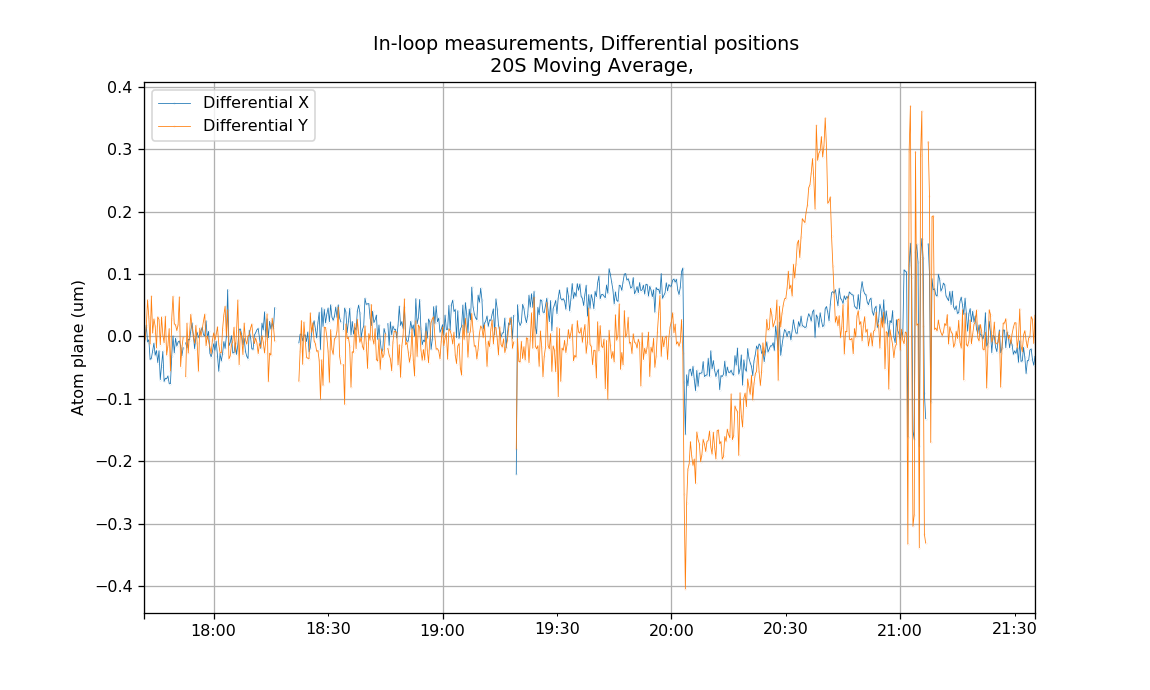

<IPython.core.display.Javascript object>


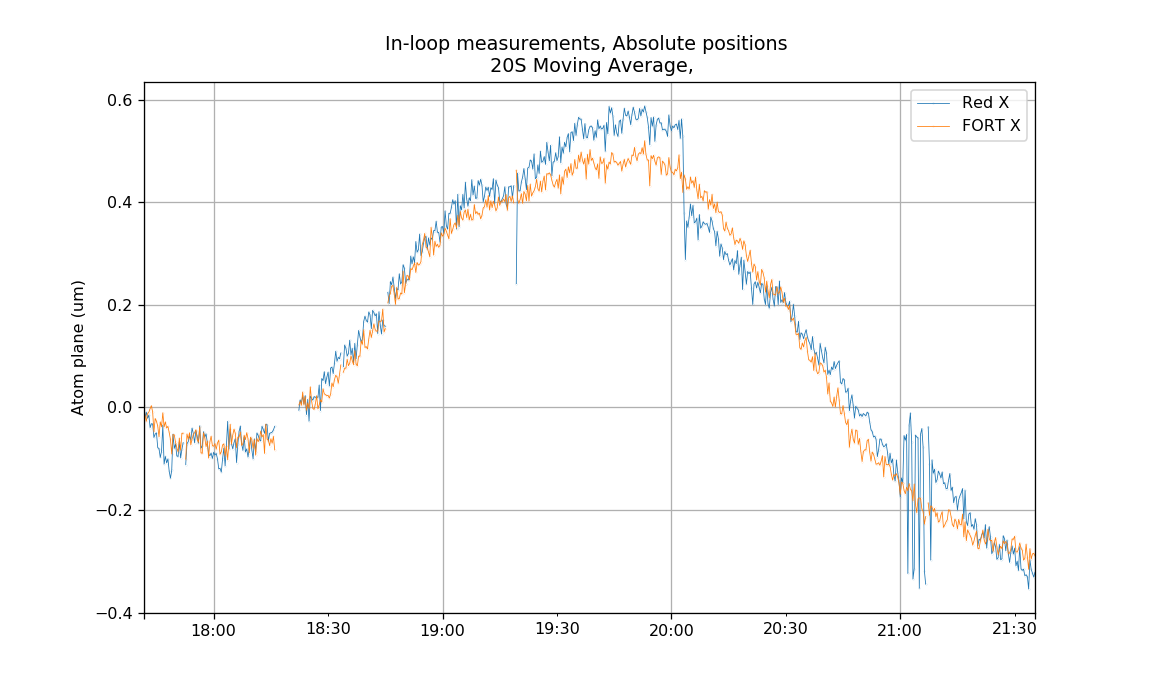

<IPython.core.display.Javascript object>


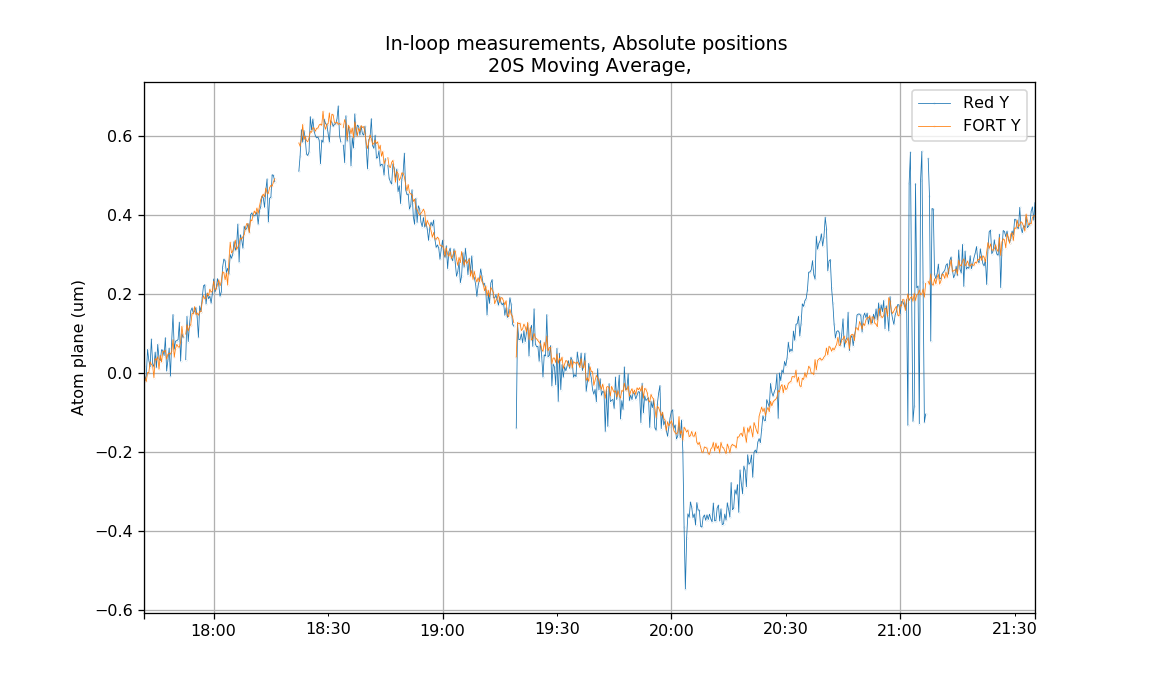

<IPython.core.display.Javascript object>


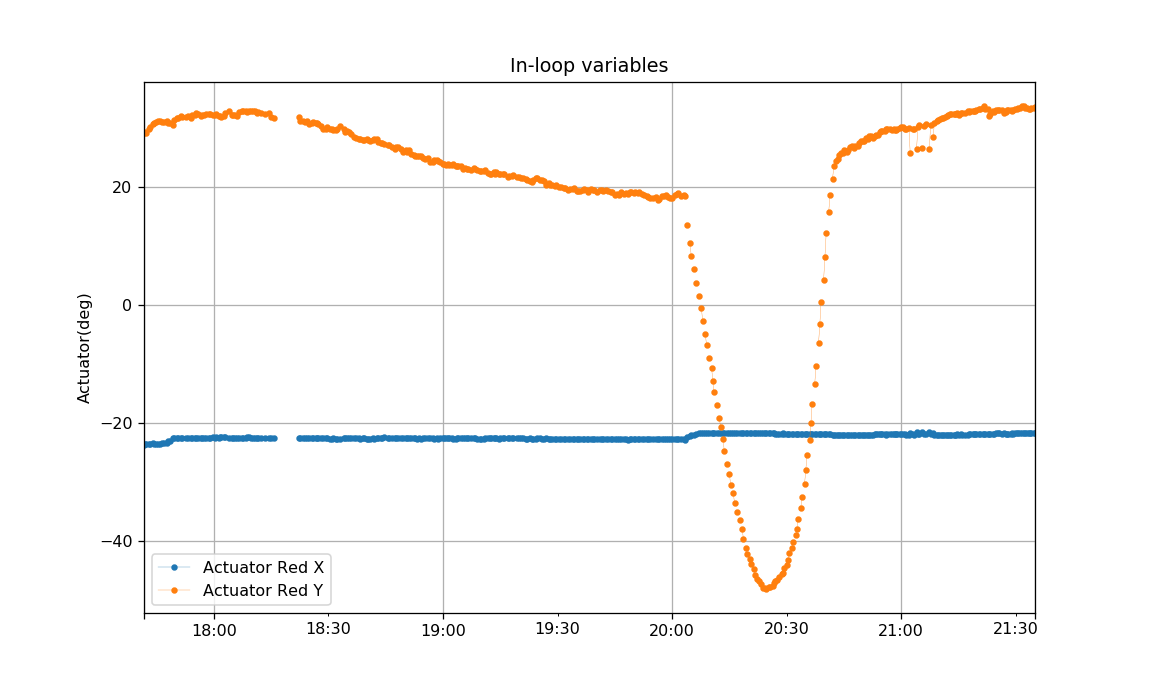

In [155]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

offset_Red_X=np.mean(flatteneddata0[0:100])#np.median(flatteneddata0)
offset_Red_Y=np.mean(flatteneddata1[0:100])#np.median(flatteneddata1)
offset_FORT_X=np.mean(flatteneddata2[0:100])#np.median(flatteneddata2)
offset_FORT_Y=np.mean(flatteneddata3[0:100])#np.median(flatteneddata3)

offsetX0=np.mean((flatteneddata0-flatteneddata2)[0:100])
offsetX_median=np.median(flatteneddata0-flatteneddata2)
offsetY0=np.mean((flatteneddata1-flatteneddata3)[0:100])
offsetY_median=np.median(flatteneddata1-flatteneddata3)
df_camera=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX0,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY0,
                 'Red X': flatteneddata0-offset_Red_X,
                 'Red Y': flatteneddata1-offset_Red_Y,
                 'FORT X': flatteneddata2-offset_FORT_X,
                 'FORT Y': flatteneddata3-offset_FORT_Y,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)

samplerate='20S'
## 
data_to_plot2=df_camera.resample(samplerate).mean()
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Differential X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['Differential Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Differential positions \n {} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

##
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Red X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['FORT X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Absolute positions \n {} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Red Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['FORT Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Absolute positions \n{} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.',ax=ax)
data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.',ax=ax)
ax.set_title('In-loop variables'.format(samplerate))
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()


<IPython.core.display.Javascript object>


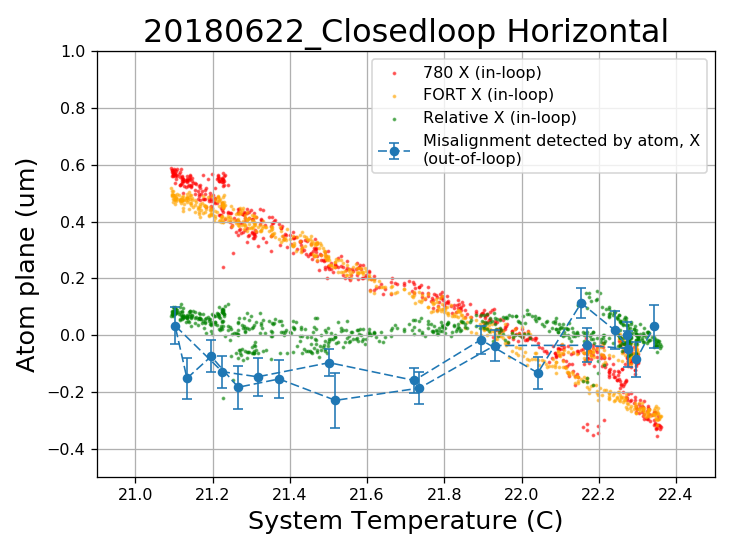

<IPython.core.display.Javascript object>


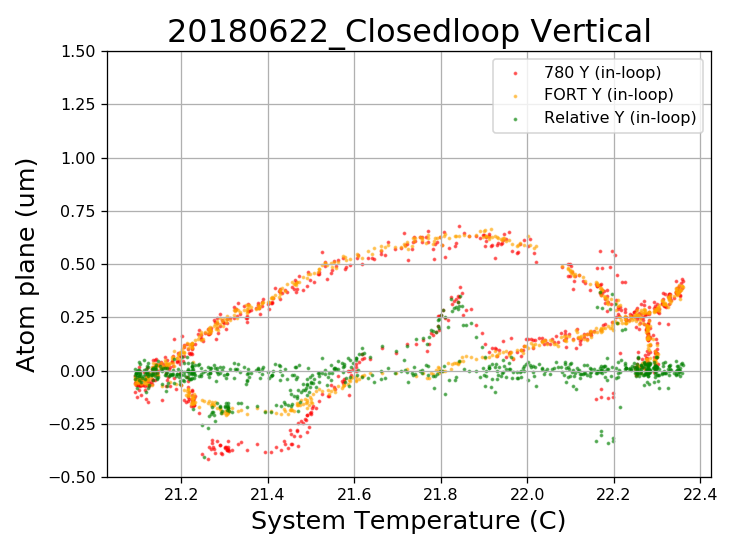

In [156]:
filename='20180622_Closedloop'
savefig=False
frames=[df_temperature,df,df_displacement,df_camera]
result=pd.concat(frames)
samplerate='20S'
data_to_plot3=result.resample(samplerate).mean()
fig, ax = plt.subplots()
data_to_plot3.plot(kind='scatter',y='Red X',x='System Temperature',alpha=0.5,s=2,color='r',label='780 X (in-loop)',ax=ax)
data_to_plot3.plot(kind='scatter',y='FORT X',x='System Temperature',alpha=0.5,s=2,color='orange',ax=ax,label='FORT X (in-loop)')
data_to_plot3.plot(kind='scatter',y='Differential X',x='System Temperature',alpha=0.5,s=2,color='green',ax=ax,label='Relative X (in-loop)')
data_to_plot3.dropna().plot(y="Displacment from the bias point",yerr='Max_error',x='System Temperature',capsize=3,lw=1,marker='o',alpha=1,linestyle='--',markersize=5,ax=ax,label='Misalignment detected by atom, X\n(out-of-loop)')
#data_to_plot3.plot(y="Displacment from the bias point",yerr='Max_error',x='System Temperature',capsize=3,lw=1,marker='o',alpha=1,linestyle='--',markersize=5,ax=ax,label='Misalignment detected by atom, X\n(out-of-loop)')
#data_to_plot3.plot(y="Displacment from the bias point",x='System Temperature',capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'],ax=ax)
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('System Temperature (C)',fontsize=16)
ax.grid()
ax.legend()
ax.set_xlim(20.9,22.5)
ax.set_ylim(-0.5,1)
ax.set_title(filename+' Horizontal',fontsize=20)
plt.tight_layout()
if savefig:
    plt.savefig(filename+"_Xcurve.png")

fig, ax2 = plt.subplots()
data_to_plot3.plot(kind='scatter',y='Red Y',x='System Temperature',alpha=0.5,s=2,color='r',label='780 Y (in-loop)',ax=ax2)
data_to_plot3.plot(kind='scatter',y='FORT Y',x='System Temperature',alpha=0.5,s=2, color='orange',ax=ax2,label='FORT Y (in-loop)')
data_to_plot3.plot(kind='scatter',y='Differential Y',x='System Temperature',alpha=0.5,s=2, color='green',ax=ax2,label='Relative Y (in-loop)')
ax2.set_ylabel('Atom plane (um)',fontsize=16)
ax2.set_xlabel('System Temperature (C)',fontsize=16)
ax2.grid()
ax2.legend()
ax.set_xlim(20.9,22.5)
ax2.set_ylim(-0.5,1.5)
ax2.set_title(filename+' Vertical',fontsize=20)
plt.tight_layout()
if savefig:
    plt.savefig(filename+"_Ycurve.png")

<IPython.core.display.Javascript object>


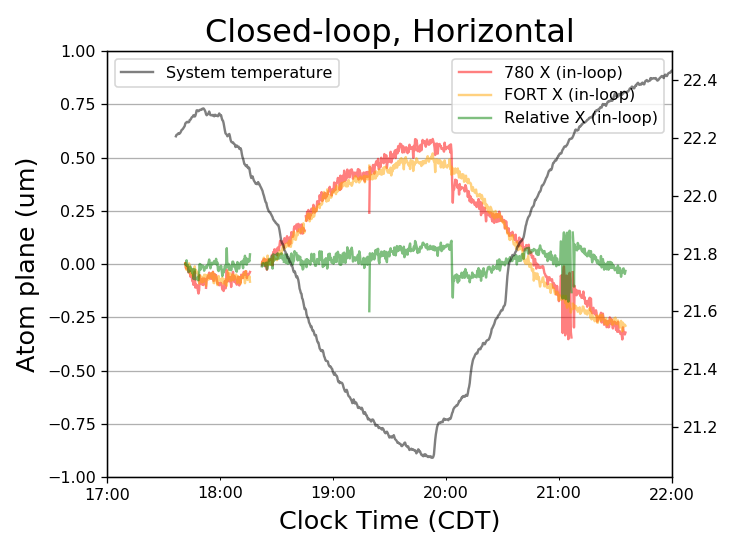

<IPython.core.display.Javascript object>


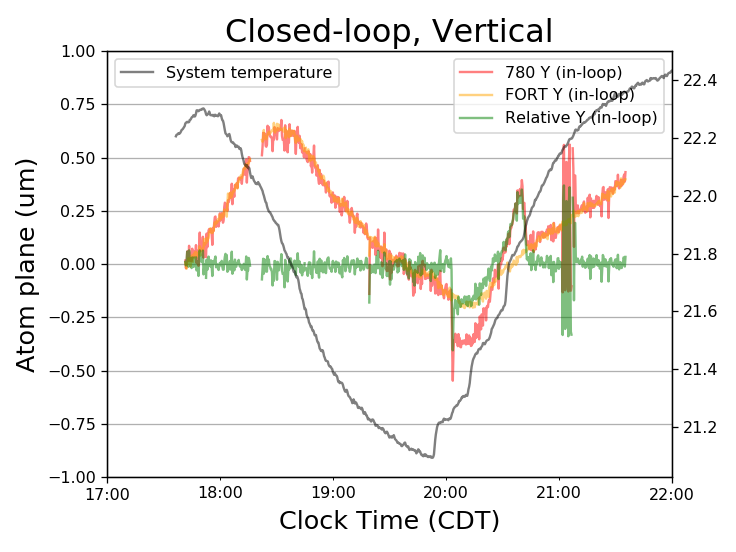

In [160]:
fig, ax = plt.subplots()
data_to_plot3.plot(y='Red X',alpha=0.5,color='r',label='780 X (in-loop)',ax=ax)
data_to_plot3.plot(y='FORT X',alpha=0.5,color='orange',ax=ax,label='FORT X (in-loop)')
data_to_plot3.plot(y='Differential X',alpha=0.5,color='green',ax=ax,label='Relative X (in-loop)')
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('Clock Time (CDT)',fontsize=16)
ax2=ax.twinx()
data_to_plot3.plot(y='System Temperature',alpha=0.5,color='black',label='System temperature',ax=ax2)
#'System Temperature'
ax.grid()
ax.legend()
ax.set_xlim(dt.datetime(2018,6,22,17,0),dt.datetime(2018,6,22,22,0))
ax.set_ylim(-1,1)
ax.set_title('Closed-loop, Horizontal',fontsize=20)
plt.tight_layout()

fig, ax = plt.subplots()
data_to_plot3.plot(y='Red Y',alpha=0.5,color='r',label='780 Y (in-loop)',ax=ax)
data_to_plot3.plot(y='FORT Y',alpha=0.5,color='orange',ax=ax,label='FORT Y (in-loop)')
data_to_plot3.plot(y='Differential Y',alpha=0.5,color='green',ax=ax,label='Relative Y (in-loop)')
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('Clock Time (CDT)',fontsize=16)
ax2=ax.twinx()
data_to_plot3.plot(y='System Temperature',alpha=0.5,color='black',label='System temperature',ax=ax2)

ax.grid()
ax.legend()
ax.set_xlim(dt.datetime(2018,6,22,17,0),dt.datetime(2018,6,22,22,0))
ax.set_ylim(-1,1)
ax.set_title('Closed-loop, Vertical',fontsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


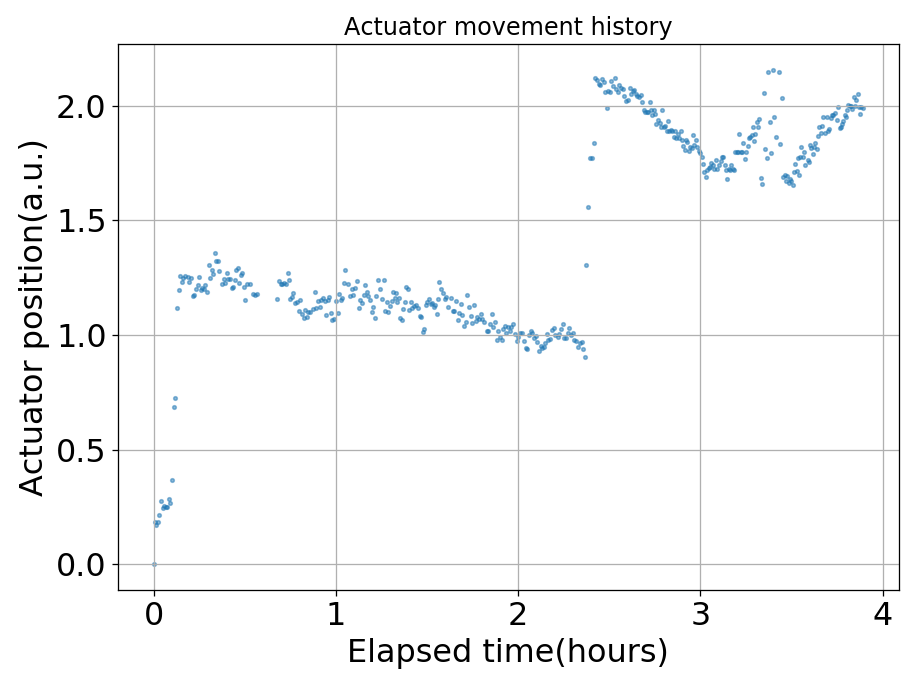

<IPython.core.display.Javascript object>


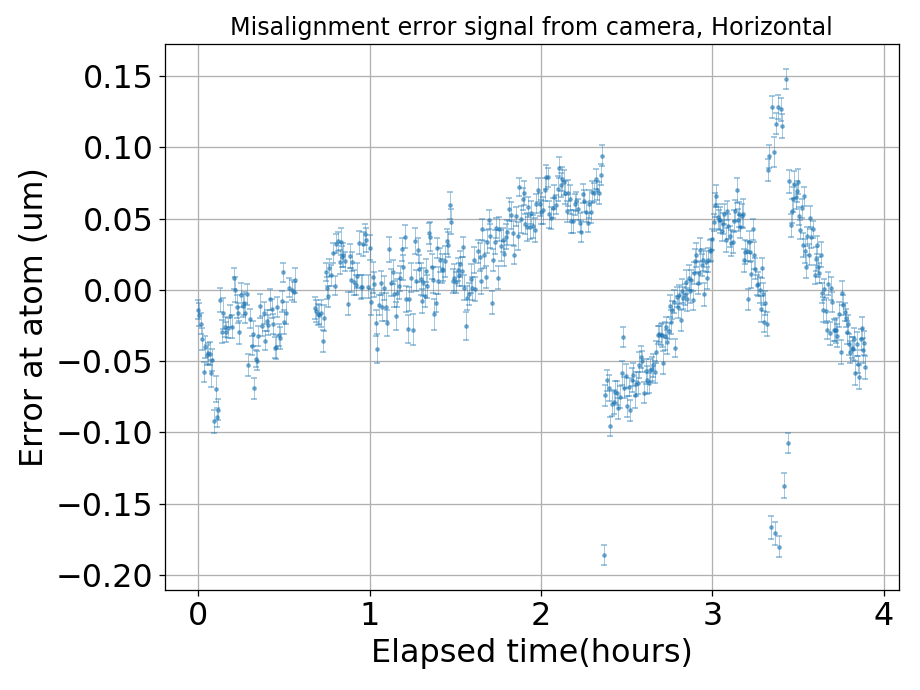

In [161]:
## Actuator Plot
savefig=False
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Horizontal',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


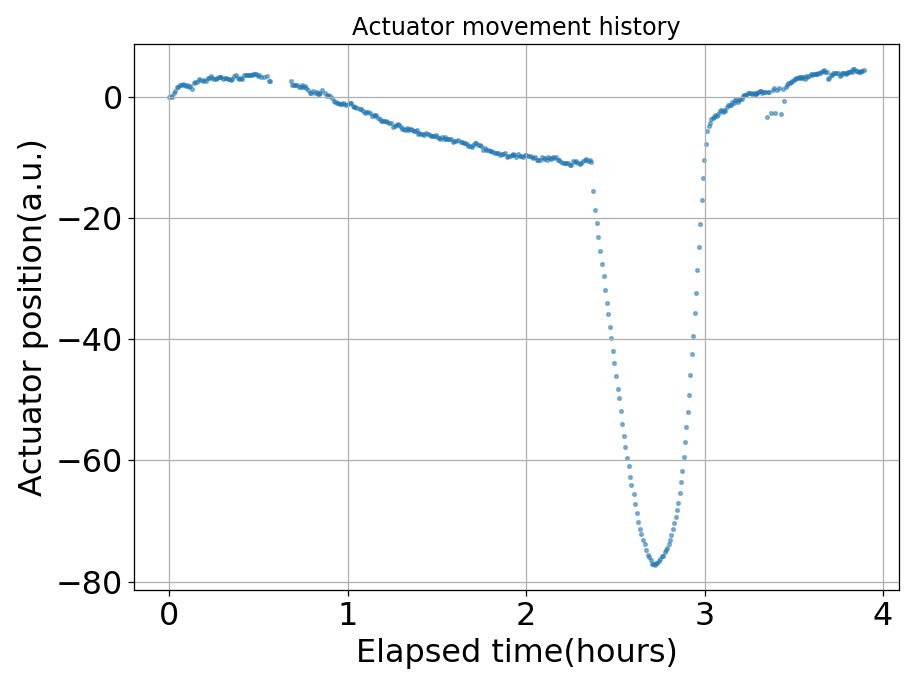

<IPython.core.display.Javascript object>


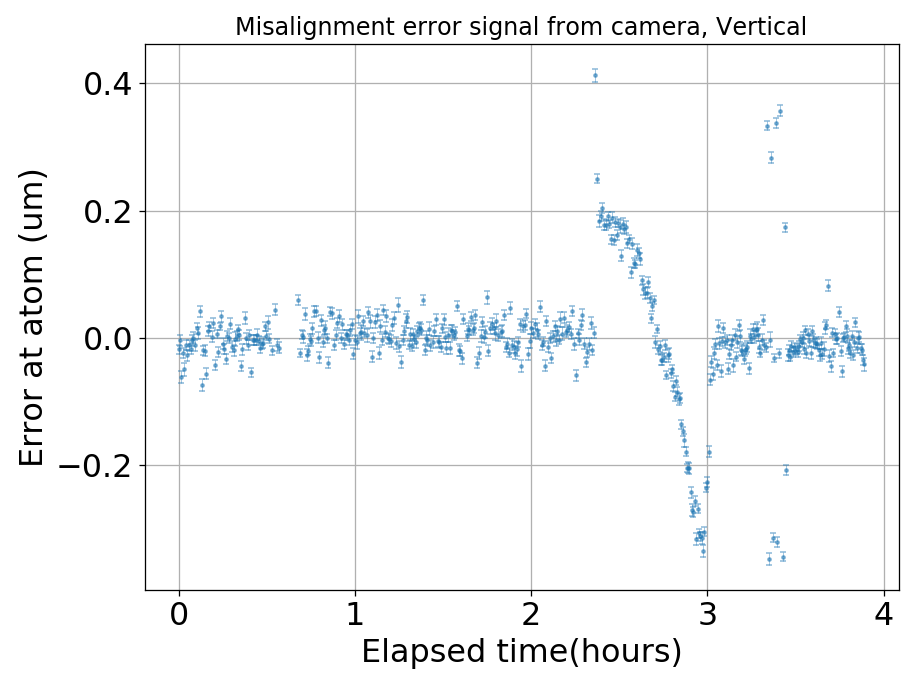

In [162]:
## Actuator Plot
savefig=False
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Vertical',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


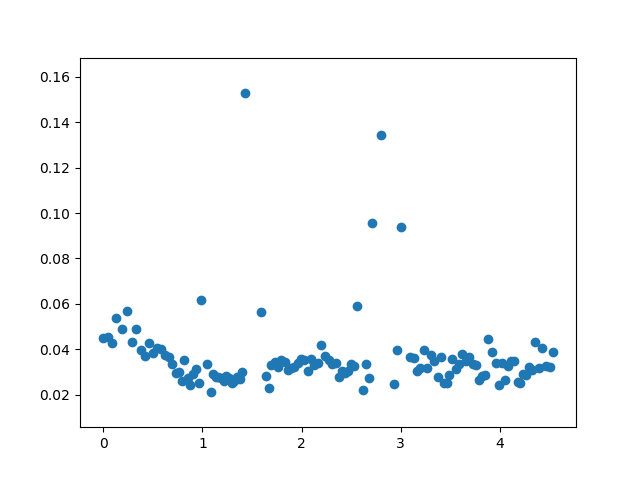

In [21]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


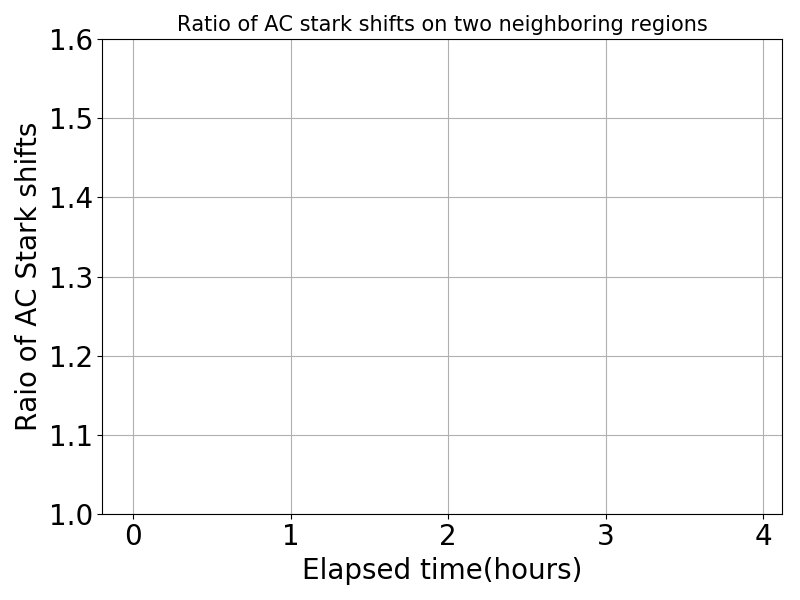

In [23]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Allan deviation

In [51]:
from IPython.display import display, clear_output
name='20180615_openloop_boxtesting'
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,10)+range(10003,100003,10)#+range(80004,100004,50)+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    
try:
    np.save(name+'_taulist',tau_list)
    np.save(name+'_X',np.sqrt(0.5*np.array(var_list['Differential X'])))
    np.save(name+'_Y',np.sqrt(0.5*np.array(var_list['Differential Y'])))
except:
    pass

'Tau: 99993'

<IPython.core.display.Javascript object>


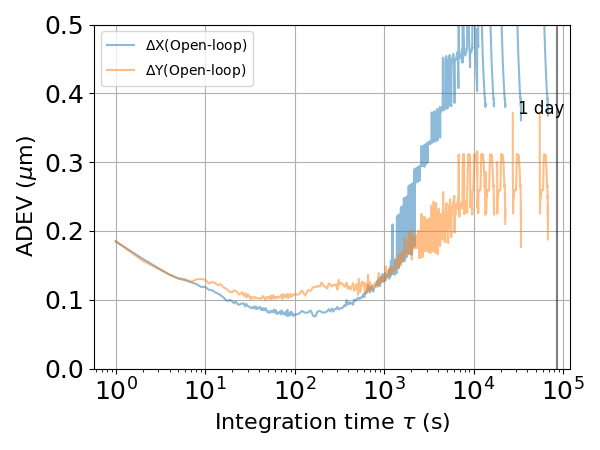

In [52]:
tau_list=np.load(name+'_taulist.npy')
Xlist=np.load(name+'_X.npy')
Ylist=np.load(name+'_Y.npy')

# tau_list2=np.load('20180525_closedloop_taulist.npy')
# Xlist2=np.load('20180525_closedloop_X.npy')
# Ylist2=np.load('20180525_closedloop_Y.npy')


savefig=False
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
ax.semilogx(tau_list, Xlist,label=r'$\Delta$X(Open-loop)',alpha=0.5)
ax.semilogx(tau_list, Ylist,label=r'$\Delta$Y(Open-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Xlist2,label=r'$\Delta$X(Closed-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Ylist2,label=r'$\Delta$Y(Closed-loop)',alpha=0.5)
ax.tick_params(labelsize=18)
ax.legend()
plt.axvline(x=86400,color='black',alpha=0.5)
#ax.set_xlim(1,)
#ax.set_title('Allan Deviation (Open-loop vs Closed-loop)',size=)
ax.set_xlabel(r'Integration time $\tau$ (s)',size=16)
ax.set_ylabel(r'ADEV ($\mu$m)',size=16)
#ax.text(10**0,0.3,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**4.5,0.37,'1 day',size=12)
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.5)
ax.grid()
plt.tight_layout()
filename='20180522_AllanDeviation_comparison'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')
